In [106]:
#from google.colab import drive
#drive.mount('/content/drive')
import zipfile
import os
import shutil
import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import TensorBoard
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
#from google.colab import files
from IPython.display import Image

In [107]:
path = './'

In [108]:
#unzip the zip file state-farm-distracted-driver-detection.zip to its same directory located in ./content/drive/MyDrive/Datamining/

if os.path.exists(path + 'imgs'):
    print("The zip file has already been extracted")
else:
    zip_file = path + 'state-farm-distracted-driver-detection.zip'
    zip_ref = zipfile.ZipFile(zip_file, 'r')
    zip_ref.extractall(path)
    zip_ref.close()

#delete the file driver_imgs_list.csv and sample_submission.csv
if os.path.exists(path + 'driver_imgs_list.csv'):
    os.remove(path + 'driver_imgs_list.csv')
if os.path.exists(path + 'sample_submission.csv'):
    os.remove(path + 'sample_submission.csv')
#delete the folder imgs/test and its images
if os.path.exists(path + 'imgs/test'):
    shutil.rmtree(path + 'imgs/test')

The zip file has already been extracted


In [109]:
#make 2 directories named test and train in the content directory with the same folders that are in the train directory
if os.path.exists(path + 'test'):
    print("The directories have already been created")
else:
    os.makedirs(path + 'test')
    os.makedirs(path + 'train')

    # Obtiene las carpetas dentro de 'train'
    folders = os.listdir(path + 'imgs/train')

    for folder in folders:
        os.makedirs(path + f'test/{folder}')
        os.makedirs(path + f'train/{folder}')

The directories have already been created


In [110]:
#for each c0-c9 folder in the train directory, move 80% of the images to the test directory randomly
#check if the content/imgs/train/c0 folder is empty
folders = os.listdir(path + 'imgs/train')
if len(os.listdir(path + 'imgs/train/c0')) != 0:
    for folder in folders:
        images = os.listdir(path + f'imgs/train/{folder}')
        random.shuffle(images)
        n = int(len(images) * 0.15)
        test_images = images[:n]
        for img in test_images:
            shutil.move(path + f'imgs/train/{folder}/{img}', path + f'test/{folder}/{img}')

    #move the remaining 20% of the images to the train directory
    for folder in folders:
        images = os.listdir(path + f'imgs/train/{folder}')
        random.shuffle(images)
        for img in images:
            shutil.move(path + f'imgs/train/{folder}/{img}', path + f'train/{folder}/{img}')
else:
    print("The images have already been moved")



The images have already been moved


In [111]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
train_generator = train_datagen.flow_from_directory(path + 'train', target_size=(96, 96), batch_size=128, class_mode='categorical', color_mode='rgb', subset = 'training')
validation_generator = train_datagen.flow_from_directory(path + 'train', target_size=(96, 96), batch_size=128, class_mode='categorical', color_mode='rgb', subset = 'validation')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(path + 'test', target_size=(96, 96), class_mode='categorical', color_mode='rgb')

Found 17164 images belonging to 10 classes.
Found 1902 images belonging to 10 classes.
Found 3358 images belonging to 10 classes.


In [112]:
# Definition of the image sizes
input_size = 96
num_colors = 3

# Definition of the network layers
layers = [
    # First convolution with 16 filters of size 3 x 3 and relu activation function
    keras.layers.Conv2D(16,(7,7),activation='relu',input_shape=(96,96,num_colors)),
    keras.layers.MaxPooling2D(2, 2),

    # Second convolution with 32 filters of size 3 x 3 and relu activation function
    keras.layers.Conv2D(32,(5,5),activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    # Third convolution with 64 filters of size 3 x 3 and relu activation function
    keras.layers.Conv2D(64,(3,3),activation='relu'),
    keras.layers.MaxPooling2D(2,2),


    # Flattening to transform the information into a vector
    keras.layers.Flatten(),
    # Dense layer with 512 neurons and relu activation function
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dense(512,activation='relu'),
    # Output layer with softmax activation function
    keras.layers.Dense(10, activation = tf.nn.softmax),
]

model = keras.Sequential(layers, name="myModel")

In [113]:
# Optimization algorithm and loss function configuration
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Network structure
model.summary()

Model: "myModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 90, 90, 16)     │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 45, 45, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 41, 41, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 18, 18, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     2,654,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,956,202 (11.28 MB)

 Trainable params: 2,956,202 (11.28 MB)

 Non-trainable params: 0 (0.00 B)

In [114]:

# Training process execution
# Iterations: 15
# Number of steps per iteration: 4 print tje loss, accuracy and validation loss and accuracy

history = model.fit(train_generator,
                    steps_per_epoch = 4,
                    epochs = 50,
                    validation_data = validation_generator,)

# Evaluation of the model using the test set
results = model.evaluate(test_generator)

print(results)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.1000 - loss: 2.3551 - val_accuracy: 0.1335 - val_loss: 2.3047
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.1208 - loss: 2.3018 - val_accuracy: 0.1220 - val_loss: 2.2985
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.1060 - loss: 2.2985 - val_accuracy: 0.1109 - val_loss: 2.2884
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.1047 - loss: 2.2871 - val_accuracy: 0.1530 - val_loss: 2.2698
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.1445 - loss: 2.2664 - val_accuracy: 0.1877 - val_loss: 2.2136
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2047 - loss: 2.1937 - val_accuracy: 0.2329 - val_loss: 2.1364
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2523 - loss: 2.0657 - val_accuracy: 0.3202 - val_loss: 1.9488
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2927 - loss: 1.9492 - val_accuracy: 0.3396 - val_loss: 1.8005
Epoch 9/50
4/4 ━

c:\Users\usuario\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9388 - loss: 0.2196 - val_accuracy: 0.9332 - val_loss: 0.2410
Epoch 35/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9385 - loss: 0.2194 - val_accuracy: 0.9127 - val_loss: 0.2739
Epoch 36/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9385 - loss: 0.1922 - val_accuracy: 0.9201 - val_loss: 0.2406
Epoch 37/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9599 - loss: 0.1451 - val_accuracy: 0.9243 - val_loss: 0.2501
Epoch 38/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9307 - loss: 0.2229 - val_accuracy: 0.9290 - val_loss: 0.2319
Epoch 39/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9312 - loss: 0.1785 - val_accuracy: 0.9390 - val_loss: 0.1985
Epoch 40/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9677 - loss: 0.1639 - val_accuracy: 0.9332 - val_loss: 0.2336
Epoch 41/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9513 - loss: 0.2048 - val_accuracy: 0.9564 - val_loss: 0.1633
Epoch 42/50
4/4 ━━━━

In [125]:
predictions = []
true_labels = []
from matplotlib.patheffects import withStroke

# Iterate over each batch in the test generator
for i in range(len(train_generator)):
    # Get batch of data and labels and predict on it
    batch_data, batch_labels = train_generator[i]
    batch_predictions = model.predict(batch_data, verbose=0)
    # Append predictions and true labels
    predictions.extend(np.argmax(batch_predictions, axis=1))
    true_labels.extend(np.argmax(batch_labels, axis=1))


cm = confusion_matrix(true_labels, predictions)

# Convert to numpy array
cm = np.array(cm)

# Calculate total samples
total_samples = np.sum(cm)

# Calculate TP, TN, FP, FN
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = total_samples - (TP + FP + FN)

# Calculate precision and recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)

# Calculate average precision and recall
average_precision = np.mean(precision)
average_recall = np.mean(recall)


# Calculate total accuracy
accuracy = results[1]

# calculate miss rate
miss_rate = 1 - accuracy

# calculate loss
loss = results[0]

# Print results
print(f"Total accuracy: {accuracy}")
print(f"Total loss: {loss}")
print(f"Average precision: {average_precision}")
print(f"Average recall: {average_recall}")
print(f"Miss rate: {miss_rate}")

# Print classification report
print(classification_report(true_labels, predictions))



Total accuracy: 0.962775468826294
Total loss: 0.13399097323417664
Average precision: 0.9719654473305053
Average recall: 0.971993332507161
Miss rate: 0.037224531173706055
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1905
           1       0.98      0.99      0.98      1735
           2       0.99      0.98      0.99      1773
           3       0.96      0.99      0.97      1796
           4       0.96      0.99      0.97      1781
           5       0.98      0.99      0.99      1770
           6       0.98      0.99      0.98      1780
           7       0.98      0.99      0.99      1532
           8       0.96      0.92      0.94      1463
           9       0.94      0.97      0.95      1629

    accuracy                           0.97     17164
   macro avg       0.97      0.97      0.97     17164
weighted avg       0.97      0.97      0.97     17164



In [126]:
predictions = []
true_labels = []
from matplotlib.patheffects import withStroke

# Iterate over each batch in the test generator
for i in range(len(validation_generator)):
    # Get batch of data and labels and predict on it
    batch_data, batch_labels = validation_generator[i]
    batch_predictions = model.predict(batch_data, verbose=0)
    # Append predictions and true labels
    predictions.extend(np.argmax(batch_predictions, axis=1))
    true_labels.extend(np.argmax(batch_labels, axis=1))


cm = confusion_matrix(true_labels, predictions)

# Convert to numpy array
cm = np.array(cm)

# Calculate total samples
total_samples = np.sum(cm)

# Calculate TP, TN, FP, FN
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = total_samples - (TP + FP + FN)

# Calculate precision and recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)

# Calculate average precision and recall
average_precision = np.mean(precision)
average_recall = np.mean(recall)


# Calculate total accuracy
accuracy = results[1]

# calculate miss rate
miss_rate = 1 - accuracy

# calculate loss
loss = results[0]

# Print results
print(f"Total accuracy: {accuracy}")
print(f"Total loss: {loss}")
print(f"Average precision: {average_precision}")
print(f"Average recall: {average_recall}")
print(f"Miss rate: {miss_rate}")

# Print classification report
print(classification_report(true_labels, predictions))



Total accuracy: 0.962775468826294
Total loss: 0.13399097323417664
Average precision: 0.9559576548340898
Average recall: 0.9561276119199242
Miss rate: 0.037224531173706055
              precision    recall  f1-score   support

           0       0.99      0.85      0.92       211
           1       0.96      0.98      0.97       192
           2       0.97      0.98      0.98       197
           3       0.96      0.97      0.97       199
           4       0.95      0.98      0.97       197
           5       0.99      0.98      0.99       196
           6       0.96      0.97      0.96       197
           7       0.93      0.99      0.96       170
           8       0.94      0.86      0.90       162
           9       0.90      0.97      0.93       181

    accuracy                           0.96      1902
   macro avg       0.96      0.96      0.96      1902
weighted avg       0.96      0.96      0.96      1902



In [128]:
predictions = []
true_labels = []
from matplotlib.patheffects import withStroke

# Iterate over each batch in the test generator
for i in range(len(test_generator)):
    # Get batch of data and labels and predict on it
    batch_data, batch_labels = test_generator[i]
    batch_predictions = model.predict(batch_data, verbose=0)
    # Append predictions and true labels
    predictions.extend(np.argmax(batch_predictions, axis=1))
    true_labels.extend(np.argmax(batch_labels, axis=1))


cm = confusion_matrix(true_labels, predictions)

# Convert to numpy array
cm = np.array(cm)

# Calculate total samples
total_samples = np.sum(cm)

# Calculate TP, TN, FP, FN
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = total_samples - (TP + FP + FN)

# Calculate precision and recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)

# Calculate average precision and recall
average_precision = np.mean(precision)
average_recall = np.mean(recall)


# Calculate total accuracy
accuracy = results[1]

# calculate miss rate
miss_rate = 1 - accuracy

# calculate loss
loss = results[0]

# Print results
print(f"Total accuracy: {accuracy}")
print(f"Total loss: {loss}")
print(f"Average precision: {average_precision}")
print(f"Average recall: {average_recall}")
print(f"Miss rate: {miss_rate}")

# Print classification report
print(classification_report(true_labels, predictions))



Total accuracy: 0.962775468826294
Total loss: 0.13399097323417664
Average precision: 0.9622427768878362
Average recall: 0.9621412643474712
Miss rate: 0.037224531173706055
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       373
           1       0.96      0.98      0.97       340
           2       0.98      0.97      0.98       347
           3       0.97      0.98      0.97       351
           4       0.95      0.98      0.96       348
           5       0.98      0.99      0.99       346
           6       0.97      0.98      0.98       348
           7       0.96      0.99      0.98       300
           8       0.94      0.89      0.92       286
           9       0.93      0.95      0.94       319

    accuracy                           0.96      3358
   macro avg       0.96      0.96      0.96      3358
weighted avg       0.96      0.96      0.96      3358



In [122]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
#from the classification report get the precision, recall and f1-score for each class
df = classification_report(true_labels, predictions, target_names=labels, output_dict=True)

df = pd.DataFrame(df).transpose() 

df.drop(columns=['support'], inplace=True)
#drop rows acuracy, macro avg, weighted avg
df.drop(['accuracy', 'macro avg', 'weighted avg'], inplace=True)
#make the index be a column and rename them 0,1,2,3,4,5,6,7,8,9
df.reset_index(level=0, inplace=True)
df.rename(columns={'index':'class'}, inplace=True)
df['class'] = [0,1,2,3,4,5,6,7,8,9]

df




,class,precision,recall,f1-score
0,0,0.974212,0.911528,0.941828
1,1,0.956897,0.979412,0.968023
2,2,0.982456,0.968300,0.975327
3,3,0.968927,0.977208,0.973050
4,4,0.947368,0.982759,0.964739
5,5,0.982808,0.991329,0.987050
6,6,0.968839,0.982759,0.975749
7,7,0.964169,0.986667,0.975288
8,8,0.944444,0.891608,0.917266
9,9,0.932308,0.949843,0.940994


In [117]:

fig = px.parallel_coordinates(df, color='precision', labels={'class': 'Classes','f1-score': 'F1-Score',  'recall': 'Recall', 'precision': 'Precision'},
                              dimensions=['class', 'recall', 'f1-score', 'precision'],
                            color_continuous_scale=px.colors.diverging.Tealrose,)

fig.update_layout(
    width=700,
    height=250,
    margin=dict(l=50, r=50, t=50, b=50),
    #make the font size bigger and bold
    font=dict(
        size=14,
        color='black',
        family='Arial, sans-serif'
    ))

fig.show()


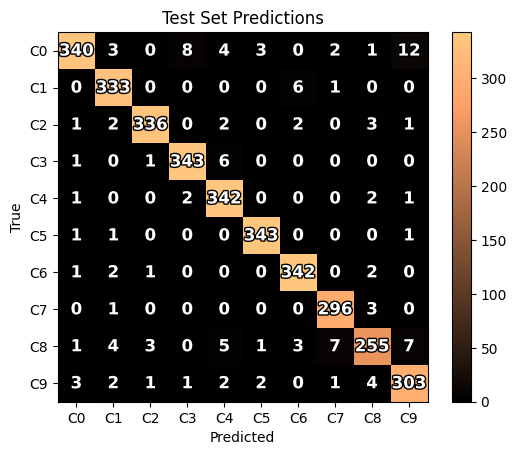

In [118]:
cm = confusion_matrix(true_labels, predictions)
labels = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(cmap='copper', text_kw={'size': 12, 'weight': 'bold', 'path_effects': [withStroke(linewidth=2, foreground='black')], 'color' : 'white'})
plt.title('Test Set Predictions')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

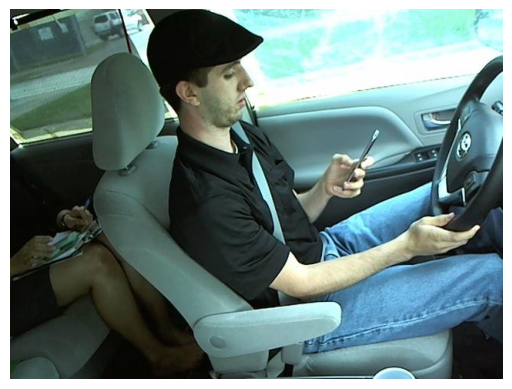

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
'Imagen is classified as:
   - texting - left with probability 0.999862909
   - talking to passenger with probability 6.6435e-05
   - safe driving with probability 4.233e-05


In [120]:
label_names = ['safe driving', 'texting - right', 'talking on the phone - right', 'texting - left', 'talking on the phone - left', 'operating the radio', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger']
minimum_value = 0.78

import math

# We use the file insertion system of Colab

# Image path configuration
path = './img_759.jpg'
# Preprocess the image
img = image.load_img(path, target_size=(96, 96))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Load and display the image
img = plt.imread(path)
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

# Image transformation into a tensor
image_tensor = np.vstack([x])
#scale the tensor values between 0 and 1
image_tensor = image_tensor / 255.0

# Inference execution
classes = model.predict(image_tensor)

# Get the indices of top three classes
top_three_indices = np.argsort(classes[0])[::-1][:3]

# Print the top three classes and their probabilities
print("'Imagen is classified as:")
for i in top_three_indices:
    probability = math.trunc(classes[0][i]*1000000000)/1000000000
    print(f"   - {label_names[i]} with probability {probability}")

# If no class meets the threshold
if not any(classes[0][i] > minimum_value for i in range(len(classes[0]))):
    print('Image' + ' is not classified in any class.')